In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import sys
sys.path.insert(0, '../')

import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pickle
import json
import matplotlib.pyplot as plt

# Importing keras from tensorflow
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Dense, Activation, LSTM, GRU, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay


from models import LSTM as lstm_impl
from models import CNN_LSTM as cnn_lstm_impl
from models import utils as model_utils
from models import transformer as tr_impl
from labels import utils as lbl_utils

2023-12-20 22:05:26.069040: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-20 22:05:26.069062: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-20 22:05:26.069075: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-20 22:05:26.072404: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-20 22:05:26.519624: W tensorflow/compiler/

In [2]:
raw_data, features_df, labels_dict = model_utils.get_aligned_raw_feat_lbl(
    '../artifacts/features/features_2009-06-22_2023-10-30.csv',
    '../artifacts/labels/labels_dict_2000-2023_w_23y_params.pkl'
)

print('label keys: ', labels_dict.keys())

[*********************100%%**********************]  1 of 1 completed
label keys:  dict_keys(['ct_two_state', 'ct_three_state', 'fixed_time_horizon', 'oracle', 'triple_barrier'])


In [3]:
for label_key, label_series in labels_dict.items():
    print(f"Count of unique values for {label_key}:")
    print(label_series.value_counts())

Count of unique values for ct_two_state:
1    1897
0    1715
Name: count, dtype: int64
Count of unique values for ct_three_state:
1    1899
0    1713
Name: count, dtype: int64
Count of unique values for fixed_time_horizon:
Close
1.0    1902
0.0    1710
Name: count, dtype: int64
Count of unique values for oracle:
1.0    2383
0.0    1229
Name: count, dtype: int64
Count of unique values for triple_barrier:
bin
1.0    2383
0.0    1229
Name: count, dtype: int64


In [4]:
weights_path = '../artifacts/weights/weights_2000-2023_w_lbl_23y_params.pkl'
with open(weights_path, 'rb') as file:
        sample_weights = pickle.load(file)
        
print('sample_weights label keys:', sample_weights.keys())
print('sample_weights alg keys:', sample_weights['ct_two_state'].keys())

sample_weights label keys: dict_keys(['ct_two_state', 'ct_three_state', 'fixed_time_horizon', 'oracle', 'triple_barrier'])
sample_weights alg keys: dict_keys(['backward_looking', 'forward_looking', 'sequential_return', 'trend_interval_return'])


In [5]:
print('Raw data shape:', raw_data.shape)
print('Features shape:', features_df.shape)
print('Labels shape:', labels_dict['ct_two_state'].shape)

Raw data shape: (3612, 6)
Features shape: (3612, 33)
Labels shape: (3612,)


In [6]:
def get_X(data, window_size):
    # Normalize features to range between -1 and 1
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_data = scaler.fit_transform(data.values)

    # Create the 3D input data shape [samples, time_steps, features] and retain dates
    X = []
    dates = []
    for i in range(window_size, len(scaled_data)):
        X.append(scaled_data[i-window_size:i, :].flatten())
        dates.append(data.index[i])

    # Convert to a DataFrame
    X_df = pd.DataFrame(X, index=dates)

    return X_df

def get_Y(labels: pd.Series, window_size):
    return labels[window_size:]

window_size = 60
example_X = get_X(raw_data, window_size)
example_Y = get_Y(labels_dict['ct_two_state'], window_size)


print('example_X - start end dates:', example_X.index[0], example_X.index[-1])
print('example_Y - start end dates:', example_Y.index[0], example_Y.index[-1])

example_X - start end dates: 2009-09-16 00:00:00 2023-10-30 00:00:00
example_Y - start end dates: 2009-09-16 00:00:00 2023-10-30 00:00:00


In [8]:
raw_X = model_utils.get_X(raw_data, 60)
raw_Y_dict = {key: model_utils.get_Y(series, 60) for key, series in labels_dict.items()}
feat_X = model_utils.get_X(features_df, 30)[30:]
feat_Y_dict = {key: model_utils.get_Y(series, 30)[30:] for key, series in labels_dict.items()}

# Determine the indices for splitting the data
total_samples = raw_X.shape[0]
train_end = int(total_samples * 0.75)
val_end = int(total_samples * 0.90)

# Split the data
raw_X_train = raw_X[:train_end]
raw_X_val = raw_X[train_end:val_end]
raw_X_test = raw_X[val_end:]
feat_X_train = feat_X[:train_end]
feat_X_val = feat_X[train_end:val_end]
feat_X_test = feat_X[val_end:]

# Splitting the Y data
raw_Y_train_dict, raw_Y_val_dict, raw_Y_test_dict = {}, {}, {}
feat_Y_train_dict, feat_Y_val_dict, feat_Y_test_dict = {}, {}, {}

for key in raw_Y_dict.keys():
    raw_Y_train_dict[key] = raw_Y_dict[key][:train_end]
    raw_Y_val_dict[key] = raw_Y_dict[key][train_end:val_end]
    raw_Y_test_dict[key] = raw_Y_dict[key][val_end:]

    feat_Y_train_dict[key] = feat_Y_dict[key][:train_end]
    feat_Y_val_dict[key] = feat_Y_dict[key][train_end:val_end]
    feat_Y_test_dict[key] = feat_Y_dict[key][val_end:]

# Print the shapes of the split data
print('Raw X train shape:', raw_X_train.shape)
print('Raw X val shape:', raw_X_val.shape)
print('Raw X test shape:', raw_X_test.shape)
print('Raw Y train shape:', raw_Y_train_dict['ct_two_state'].shape)
print('Raw Y val shape:', raw_Y_val_dict['ct_two_state'].shape)
print('Raw Y test shape:', raw_Y_test_dict['ct_two_state'].shape)
print()
print('Features X train shape:', feat_X_train.shape)
print('Features X val shape:', feat_X_val.shape)
print('Features X test shape:', feat_X_test.shape)
print('Features Y train shape:', feat_Y_train_dict['ct_two_state'].shape)
print('Features Y val shape:', feat_Y_val_dict['ct_two_state'].shape)
print('Features Y test shape:', feat_Y_test_dict['ct_two_state'].shape)

Raw X train shape: (2664, 60, 6)
Raw X val shape: (532, 60, 6)
Raw X test shape: (356, 60, 6)
Raw Y train shape: (2664,)
Raw Y val shape: (532,)
Raw Y test shape: (356,)

Features X train shape: (2664, 30, 33)
Features X val shape: (532, 30, 33)
Features X test shape: (356, 30, 33)
Features Y train shape: (2664,)
Features Y val shape: (532,)
Features Y test shape: (356,)


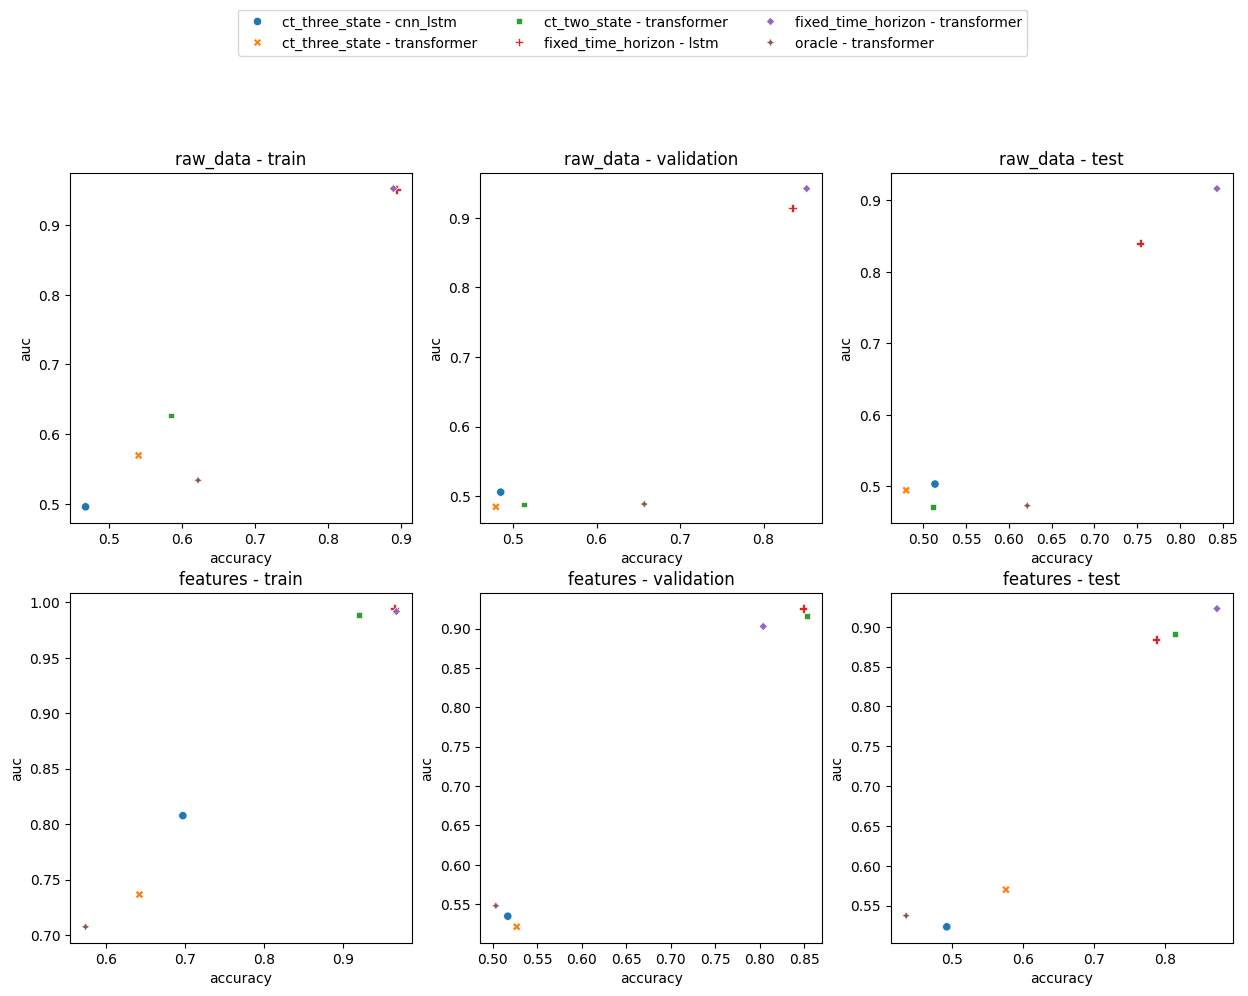

In [ ]:
metrics_df = model_utils.plot_acc_auc('../artifacts/models/test_logs/old_best_comb/metrics.json')

In [ ]:
filtered_df = metrics_df[
    (metrics_df['accuracy'] > 0.6) & (metrics_df['accuracy'] <= 1.1) &
    (metrics_df['auc'] > 0.6) & (metrics_df['auc'] <= 1.1)
]

print(filtered_df[['features_used', 'model_name', 'labeling_algorithm']].drop_duplicates())

   features_used   model_name  labeling_algorithm
9       raw_data         lstm  fixed_time_horizon
12      raw_data  transformer  fixed_time_horizon
18      features  transformer      ct_three_state
21      features  transformer        ct_two_state
24      features     cnn_lstm  fixed_time_horizon
27      features         lstm  fixed_time_horizon
30      features  transformer  fixed_time_horizon


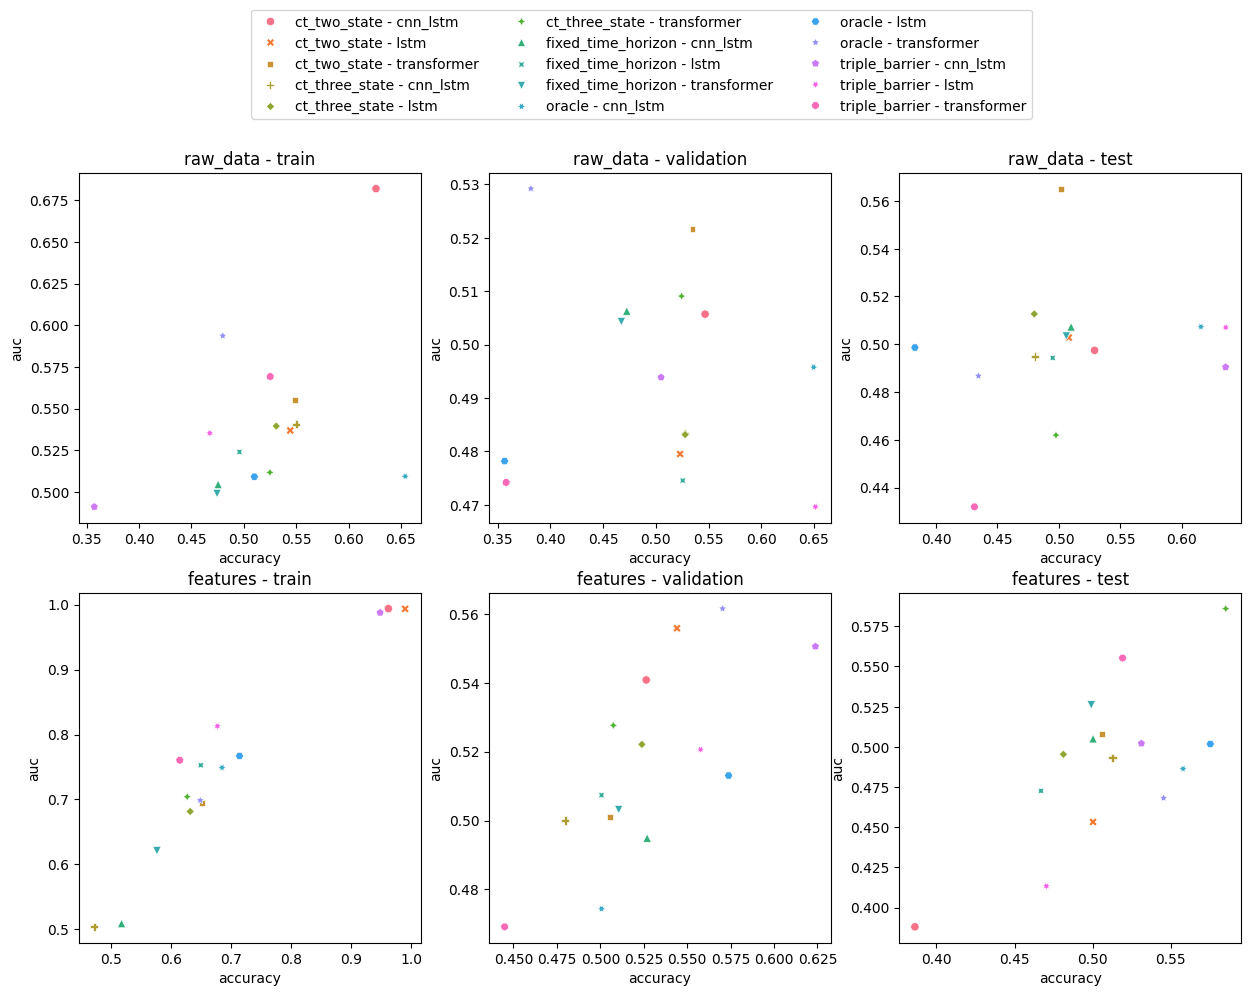

In [ ]:
metrics_df = model_utils.plot_acc_auc('../artifacts/models/test_logs/all_comb_patience_15/metrics.json')

In [ ]:
filtered_df = metrics_df[
    (metrics_df['accuracy'] > 0.6) & (metrics_df['accuracy'] <= 1.1) &
    (metrics_df['auc'] > 0.6) & (metrics_df['auc'] <= 1.1)
]

print(filtered_df[['features_used', 'model_name', 'labeling_algorithm']].drop_duplicates())

   features_used   model_name  labeling_algorithm
0       raw_data     cnn_lstm        ct_two_state
45      features     cnn_lstm        ct_two_state
48      features         lstm        ct_two_state
51      features  transformer        ct_two_state
57      features         lstm      ct_three_state
60      features  transformer      ct_three_state
66      features         lstm  fixed_time_horizon
72      features     cnn_lstm              oracle
75      features         lstm              oracle
78      features  transformer              oracle
81      features     cnn_lstm      triple_barrier
84      features         lstm      triple_barrier
87      features  transformer      triple_barrier


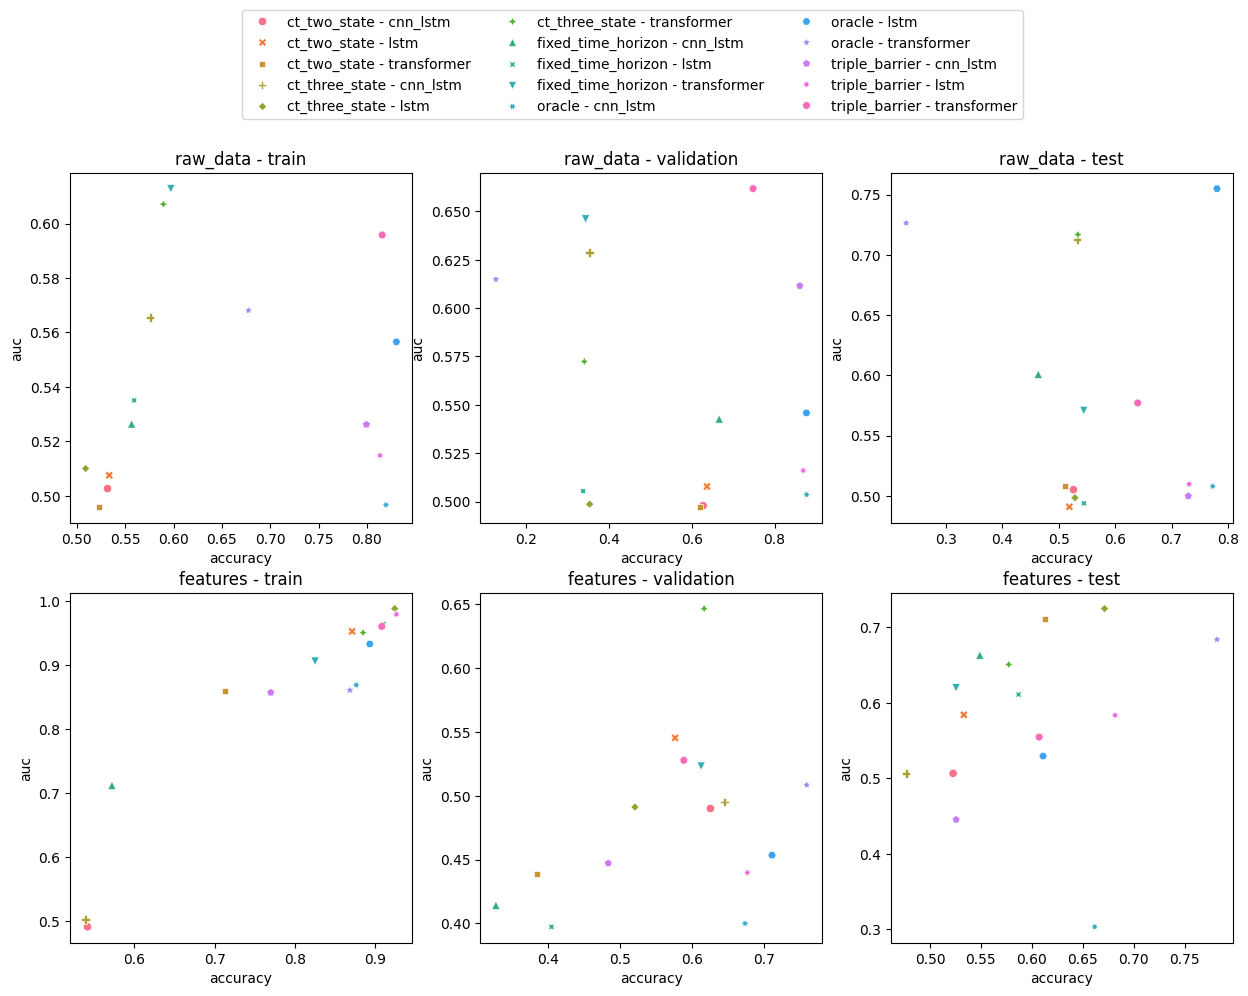

In [ ]:
metrics_df = model_utils.plot_acc_auc('../artifacts/models/test_logs/all_comb_weighted_trend_interval_return_patience_20/metrics.json')

In [ ]:
filtered_df = metrics_df[
    (metrics_df['accuracy'] > 0.6) & (metrics_df['accuracy'] <= 1.1) &
    (metrics_df['auc'] > 0.6) & (metrics_df['auc'] <= 1.1)
]

print(filtered_df[['features_used', 'model_name', 'labeling_algorithm']].drop_duplicates())

   features_used   model_name  labeling_algorithm
32      raw_data         lstm              oracle
37      raw_data     cnn_lstm      triple_barrier
43      raw_data  transformer      triple_barrier
48      features         lstm        ct_two_state
51      features  transformer        ct_two_state
57      features         lstm      ct_three_state
60      features  transformer      ct_three_state
66      features         lstm  fixed_time_horizon
69      features  transformer  fixed_time_horizon
72      features     cnn_lstm              oracle
75      features         lstm              oracle
78      features  transformer              oracle
81      features     cnn_lstm      triple_barrier
84      features         lstm      triple_barrier
87      features  transformer      triple_barrier


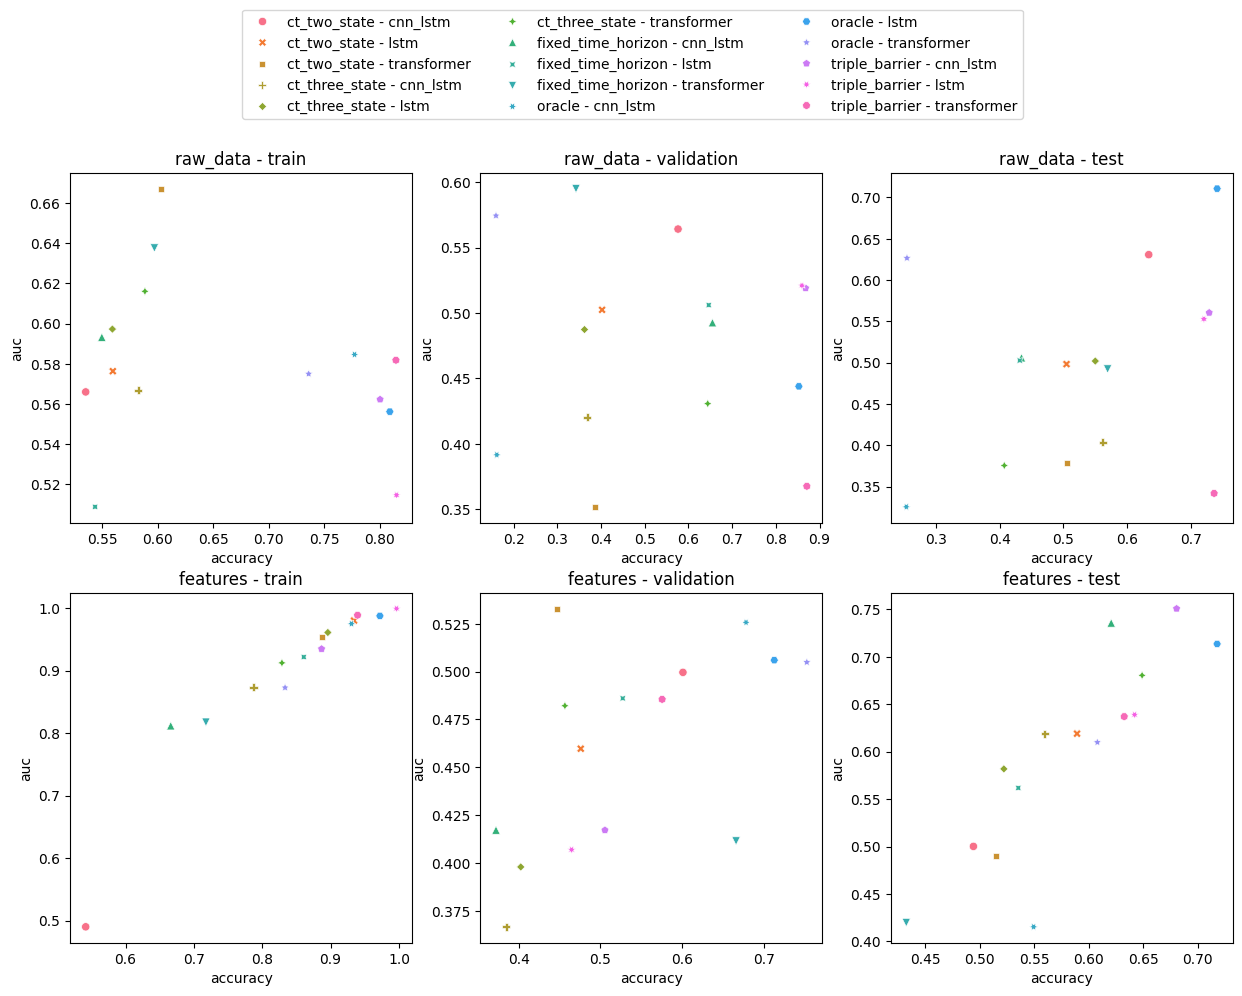

In [ ]:
metrics_df = model_utils.plot_acc_auc('../artifacts/models/test_logs/all_comb_weighted_forward_looking_patience_20/metrics.json')